In [10]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym

# Image loading packages
from PIL import Image
from io import BytesIO
import requests

image_array.shape:  (250, 250)


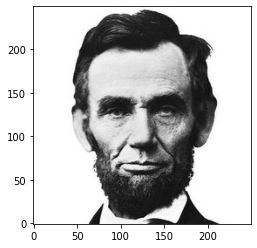

In [11]:
# Loads an online image as a numpy array
# URL of the image
image_url = 'https://raw.githubusercontent.com/MurpheyLab/ME455_public/main/figs/lincoln.jpg'

# Fetch the image data from the URL
response = requests.get(image_url)

# Create a BytesIO object from the response data
image_data = BytesIO(response.content)

# Open the image using PIL
image = Image.open(image_data)

# Convert the image to a NumPy array
image_array = np.array(image)
image_array = np.flip(image_array, axis=0)

print('image_array.shape: ', image_array.shape)

plt.imshow(image_array, origin='lower', cmap='gray') # note that for "imshow" the origin of the coordinate is at top left instead of bottom left
plt.show()
plt.close()

In [12]:
xgrids = np.linspace(0.0, 1.0, image_array.shape[0])  # the x coordinates of image pixels in the new space
dx = xgrids[1] - xgrids[0]
ygrids = np.linspace(0.0, 1.0, image_array.shape[1])  # the y coordinates of image pixels in the new space
dy = ygrids[1] - ygrids[0]

# we now invert dark and light pixel density and normalize the density values so it is a valid probability distribution
density_array = 255.0 - image_array  # we want higher density at darker regions
density_array /= np.sum(density_array) * dx * dy  # so the integral is 1

def image_density(s):
    """ Continuous density function based on the image
    Inputs:
        s - a numpy array containing the (x,y) coordinate within the 1m-by-1m space
    Return:
        val - the density value at s
    """
    s_x, s_y = s

    # Find the pixel closest to s in the 1-by-1 space
    # Note that in image the first pixel coordinate correspond to the y-axis in the 1-by-1 space
    pixel_idx_y = np.argmin(np.abs(xgrids - s_x))
    pixel_idx_x = np.argmin(np.abs(ygrids - s_y))

    # the density at s is the same as the closest pixel density
    val = density_array[pixel_idx_x, pixel_idx_y]

    return val

#### Converting image to a continuous density function

We assume this image represents a continuous density function p(x) over a 1 meter-by-1 meter space.
In other words, we will convert the coordinate of each pixel of this 250-by-250 image to a 1m-by-1m space.

For example, the bottom right pixel has the coordinate (249,249) in the image coordinate, we will transform it to be (1.0, 1.0) in the new space.

**Note: we want higher density at regions that are darker, so we need to evaluate the density as "255 - pixel_density".**

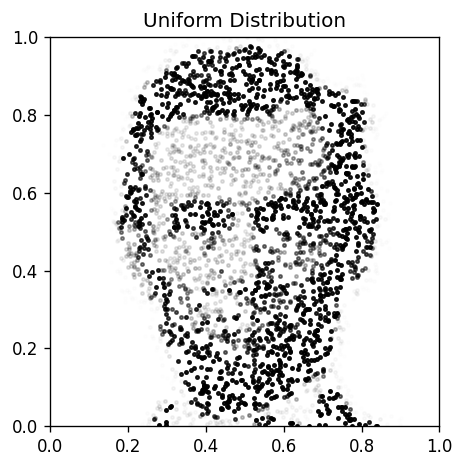

In [13]:
# Problem 1
# We can verify the density function through importance sampling
num_samples = 5000
samples = np.random.uniform(low=0.0, high=1.0, size=(num_samples,2))
sample_weights = np.zeros(num_samples)

for i in range(num_samples):
    sample_weights[i] = image_density(samples[i])

# for visualization purpose, we adjust the weights such that the maximum weight is 1.0
# (matplotlib only accepts values between 0.0 to 1.0 as the opacity value)
# (this is not the same as normalization in importance sampling or rejection sampling)
sample_weights /= np.max(sample_weights)

# now we visualize the weighted samples
fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=120, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)

for sample, weight in zip(samples, sample_weights):
    ax.plot(sample[0], sample[1], linestyle='', marker='o', markersize=2, color='k', alpha=weight)

plt.title("Importance Sampling")
plt.show()
plt.close()

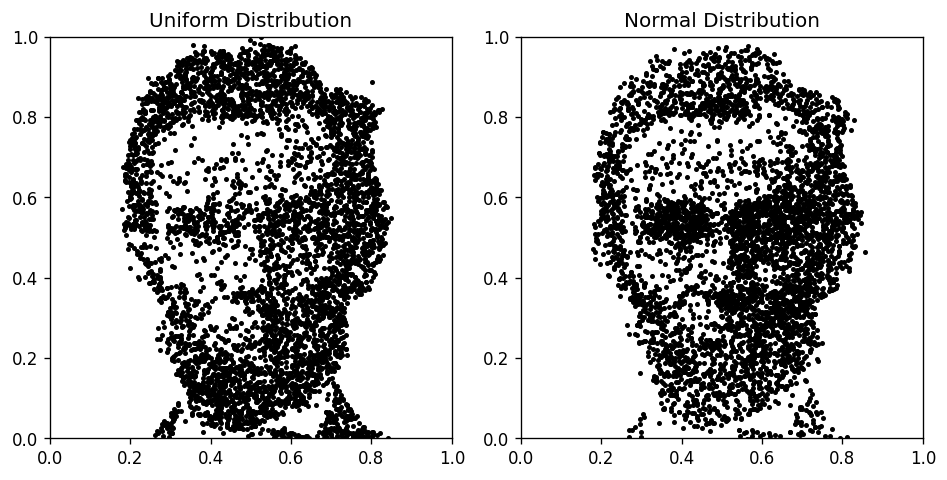

In [27]:
# We can verify the density function through importance sampling
num_samples = 5000

## rejection sampling
def rejection_sample(num_samples, M, sample_type=0):
    accepted_samples = []
    while len(accepted_samples) < num_samples:
        scalar_sample = np.random.uniform(low=0.0, high=1.0)

        if sample_type == 0:
            # uniform sampling
            sample = np.random.uniform(low=0.0, high=1.0, size=2)
        else:
            # normal sampling
            sample = np.random.normal(loc=0.50, scale=0.25, size=2)
        if scalar_sample*M < image_density(sample):
            accepted_samples.append(sample)

    return np.array(accepted_samples)

# now we visualize the accepted samples
fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=120, tight_layout=True)

# Plot samples for uniform distribution
axs[0].set_title("Uniform Distribution")
axs[0].set_aspect('equal')
axs[0].set_xlim(0.0, 1.0)
axs[0].set_ylim(0.0, 1.0)

acc_samples = rejection_sample(num_samples, M=5.0, sample_type=0)
for sample in acc_samples:
    axs[0].plot(sample[0], sample[1], linestyle='', marker='o', markersize=2, color='k')

# Plot samples for normal distribution
axs[1].set_title("Normal Distribution")
axs[1].set_aspect('equal')
axs[1].set_xlim(0.0, 1.0)
axs[1].set_ylim(0.0, 1.0)

acc_samples = rejection_sample(num_samples, M=5.0, sample_type=1)
for sample in acc_samples:
    axs[1].plot(sample[0], sample[1], linestyle='', marker='o', markersize=2, color='k')

plt.show()
plt.close()


Shape of traj:  (6, 62)


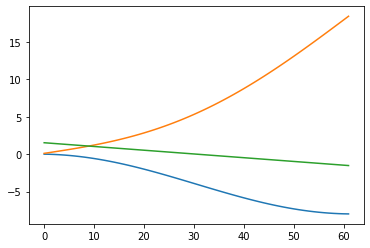

In [15]:
# t = sym.symbols('t')
# x_1 = sym.Function(r'x')(t)
# y_1 = sym.Function(r'y')(t)
# theta1 = sym.Function(r'\theta')(t)


# q = sym.Matrix([x_1, y_1, theta1])
# q_dot = q.diff(t)
# q_ddot = q_dot.diff(t)

# q_dot[0] = sym.cos(theta1)
# q_dot[1] = sym.sin(theta1)
# q_dot[2] = sym.cos(-0.5)



def integrate(f, xt, dt):
    """
    This function takes in an initial condition x(t) and a timestep dt,
    as well as a dynamical system f(x) that outputs a vector of the
    same dimension as x(t). It outputs a vector x(t+dt) at the future
    time step.

    Parameters
    ============
    dyn: Python function
        derivate of the system at a given step x(t),
        it can considered as \dot{x}(t) = func(x(t))
    xt: NumPy array
        current step x(t)
    dt:
        step size for integration

    Return
    ============
    new_xt:
        value of x(t+dt) integrated from x(t)
    """
    k1 = dt * f(xt)
    k2 = dt * f(xt+k1/2.)
    k3 = dt * f(xt+k2/2.)
    k4 = dt * f(xt+k3)
    new_xt = xt + (1/6.) * (k1+2.0*k2+2.0*k3+k4)
    return new_xt

def simulate(f, x0, tspan, dt, integrate):
    """
    This function takes in an initial condition x0, a timestep dt,
    a time span tspan consisting of a list [min_time, max_time],
    as well as a dynamical system f(x) that outputs a vector of the
    same dimension as x0. It outputs a full trajectory simulated
    over the time span of dimensions (xvec_size, time_vec_size).

    Parameters
    ============
    f: Python function
        derivate of the system at a given step x(t),
        it can considered as \dot{x}(t) = func(x(t))
    x0: NumPy array
        initial conditions
    tspan: Python list
        tspan = [min_time, max_time], it defines the start and end
        time of simulation
    dt:
        time step for numerical integration
    integrate: Python function
        numerical integration method used in this simulation

    Return
    ============
    x_traj:
        simulated trajectory of x(t) from t=0 to tf
    """
    N = int((max(tspan)-min(tspan))/dt)
    x = np.copy(x0)
    tvec = np.linspace(min(tspan),max(tspan),N)
    xtraj = np.zeros((len(x0),N))
    for i in range(N):
        xtraj[:,i]=integrate(f,x,dt)
        x = np.copy(xtraj[:,i])
    return xtraj

##############################################
# example: simulate a particle falling in gravity
def xddot(theta):
    """
    Acceleration of the particle in terms of
    position and velocity. Here it's a constant.
    """
    x_ddot = -1*np.sin(theta)
    y_ddot = np.cos(theta)
    return x_ddot, y_ddot, 0

def dyn(s):
    """
    System dynamics function (extended)

    Parameters
    ============
    s: NumPy array
        s = [x, xdot] is the extended system
        state vector, includng the position and
        the velocity of the particle

    Return
    ============
    sdot: NumPy array
        time derivative of input state vector,
        sdot = [xdot, xddot]
    """
    return np.array([s[3], s[4], s[5], *xddot(s[2])])

# define initial state
s0 = np.array([0, 0, np.pi/2, 0, 1, -0.5]) # initial conditions
# simulat from t=0 to 5, since dt=0.1, the returned trajectory
# will have 10/0.1=100 time steps, each time step contains extended
# system state vector [theta1(t), theta2(2), theta1dot(t), theta2dot(t)]
traj = simulate(dyn, s0, [0, np.pi*2], 0.1, integrate)
print('\033[1mShape of traj: \033[0m', traj.shape)


fig, ax = plt.subplots()
# tvec = np.linspace(min(tspan),max(tspan), 500)
# ax.plot(tvec, traj[0])
# ax.plot(tvec, traj[1])
plt.plot(traj[0])
plt.plot(traj[1])
plt.plot(traj[2])

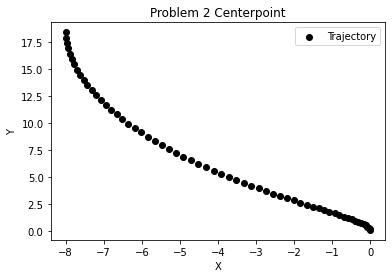

In [16]:
# Problem 2

# # Create trajectory
# time = 0.0
# x_traj = []
# y_traj = []
# while time <= 2*np.pi:
#     theta = (np.pi * 0.5) + (time * -0.5)
#     x_val = np.cos(theta) * time
#     y_val = np.sin(theta) * time
#     x_traj.append(x_val)
#     y_traj.append(y_val)
#     time += 0.1

# Create dummy scatter plots for legend
plt.scatter(traj[0], traj[1], color='black', label='Trajectory')
# plt.scatter([], [], color='red', label='Negative')

# L_mat = compute_L(X, Y, sampled_locations, results)
# Add legend
# plt.imshow(L_mat, extent=[0, 1, 0, 1], cmap='gray',
#            origin='lower', aspect='auto')
plt.legend(loc='upper right')
# plt.colorbar(label='Center heatmap prob')
plt.title('Problem 2 Centerpoint')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()